In [109]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from WindPy import w
import empyrical
from matplotlib.dates import date2num
%matplotlib inline

In [2]:
def metric(daily_ret):
    an_ret = empyrical.annual_return(daily_ret, period='monthly')
    sharpe = empyrical.sharpe_ratio(daily_ret, risk_free=0.015/365, period='monthly')
    vol = empyrical.annual_volatility(daily_ret, period='monthly')
    maxdraw = empyrical.max_drawdown(daily_ret)
    print('Annual return: %.2f%%'%(an_ret*100))
    print('Sharpe ratio: %.2f'%(sharpe))
    print('Annual volatility: %.2f%%'%(vol*100))
    print('Max drawdown: %.2f%%'%(maxdraw*100))

In [3]:
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2017 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

In [4]:
start_date, end_date = '2005-01-01', datetime.datetime.today()

In [5]:
econ_data = w.edb('M0330163,S0059749', start_date, end_date)

In [6]:
econ_df = pd.DataFrame(np.array(econ_data.Data).T, index=econ_data.Times, columns=['ey', 'by'])
econ_df.index = pd.to_datetime(econ_df.index)

In [7]:
gap = 100. / econ_df['ey'] - econ_df['by']

In [8]:
gap = gap.resample('M').mean()

In [69]:
div_data = w.wsd('000300.SH', 'dividendyield2,pe_ttm', start_date, end_date, 'Period=M')

In [70]:
div_df = pd.DataFrame(np.array(div_data.Data).T, index=div_data.Times, columns=['dividend', 'pe'])
div_df.index = pd.to_datetime(div_df.index)

In [80]:
gap2 = div_df['dividend'].resample('M').last() - econ_df['by'].resample('M').last()

In [40]:
data = w.wsd('000300.SH,000905.SH,CBA00101.CS', 'close', start_date, end_date, 'Period=M')

In [41]:
df = pd.DataFrame(np.array(data.Data).T, index=data.Times, columns=['300', '500', 'bond'])
df.index = pd.to_datetime(df.index)

In [42]:
df.tail()

,300,500,bond
2019-06-28,3825.5873,4950.4798,191.1070
2019-07-31,3835.3589,4903.2030,192.2864
2019-08-30,3799.5863,4886.4940,193.4627
2019-09-30,3814.5282,4940.9030,193.7762
2019-10-09,3843.2392,4982.9535,194.0224


In [43]:
ret_df = df.pct_change()
ret_df = ret_df.fillna(0)

In [85]:
base_portfolio_ret = ret_df.mul([0.45, 0.45, 0.1], axis=1).sum(axis=1)

# EY-BY策略

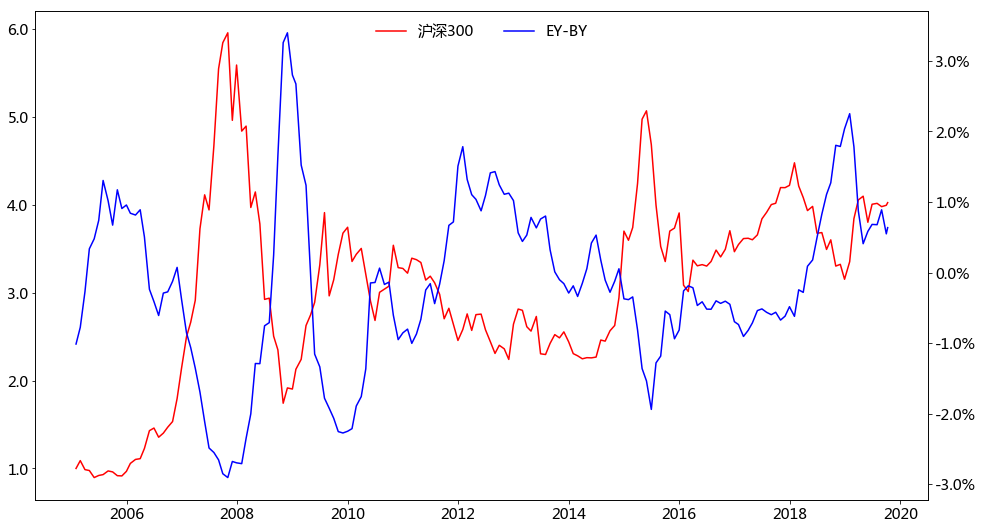

In [86]:
fig, ax = plt.subplots(figsize=(16, 9))

lns1 = ax.plot((1 + ret_df['300']).cumprod(), label=u'沪深300', color='red')
axx = ax.twinx()
lns2 = axx.plot(gap, label=u'EY-BY', color='blue')
# lns2 = axx.plot(gap2, label=u'DY-BY', color='blue')

lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, frameon=False, fontsize=15, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1))

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
vals = ax.get_yticks()
ax.set_yticklabels(['{:2.1f}'.format(x) for x in vals])
axx.yaxis.set_tick_params(labelsize=15)
vals = axx.get_yticks()
axx.set_yticklabels(['{:2.1f}%'.format(x) for x in vals])

_ = ax.set_title(u'', fontsize=25, y=1.02)

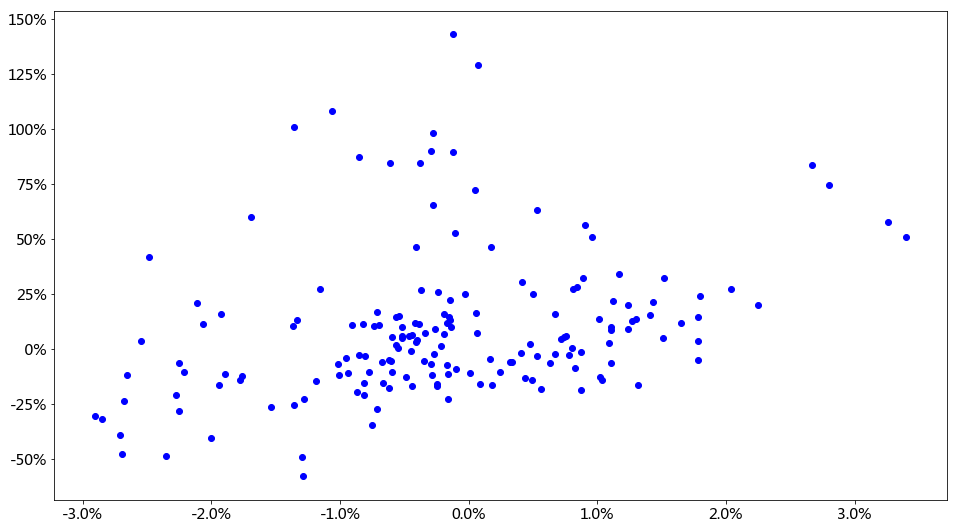

In [87]:
# 散点图
fig, ax = plt.subplots(figsize=(16, 9))

k = 6
plt.scatter(gap, df['300'].pct_change(k).shift(-k), color='blue')

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
vals = ax.get_xticks()
ax.set_xticklabels(['{:2.1f}%'.format(x) for x in vals])
vals = ax.get_yticks()
ax.set_yticklabels(['{:2.0f}%'.format(x*100) for x in vals])

_ = ax.set_title(u'', fontsize=25, y=1.02)

# 回测

In [88]:
assert(gap.shape[0] == ret_df.shape[0])

In [89]:
gap.index = ret_df.index

In [90]:
def state2weight(current_state):
    if current_state == 'median':
        return np.array([0.45, 0.45, 0.1])
    elif current_state == 'buy':
        return np.array([0.5, 0.5, 0.])
    else:
        return np.array([0.4, 0.4, 0.2])

In [91]:
up_threshold, down_threshold = 1., -1.
weight_df = pd.DataFrame(columns=ret_df.columns, index=ret_df.index)
current_state = 'median'
weight = state2weight(current_state)
for date in ret_df.index:
    weight_df.loc[date] = weight
    temp = current_state
    
    if current_state == 'median':
        if gap[date] > up_threshold:
            current_state = 'buy'
        elif gap[date] < down_threshold:
            current_state = 'sell'
    elif current_state == 'buy':
        if gap[date] < down_threshold:
            current_state = 'median'
    elif current_state == 'sell':
        if gap[date] > up_threshold:
            current_state = 'median'
            
    if temp != current_state:
        print(date.strftime('%Y-%m-%d'), '%.2f'%(gap[date]), temp, current_state)
    weight = state2weight(current_state)

('2005-01-31', '-1.01', 'median', 'sell')
('2005-07-29', '1.30', 'sell', 'median')
('2005-08-31', '1.02', 'median', 'buy')
('2007-02-28', '-1.06', 'buy', 'median')
('2007-03-30', '-1.35', 'median', 'sell')
('2008-09-26', '1.65', 'sell', 'median')
('2008-10-31', '3.26', 'median', 'buy')
('2009-05-27', '-1.16', 'buy', 'median')
('2009-06-30', '-1.34', 'median', 'sell')
('2011-12-30', '1.51', 'sell', 'median')
('2012-01-31', '1.78', 'median', 'buy')
('2015-04-30', '-1.36', 'buy', 'median')
('2015-05-29', '-1.54', 'median', 'sell')
('2018-08-31', '1.11', 'sell', 'median')
('2018-09-28', '1.27', 'median', 'buy')


In [92]:
portfolio_ret = (ret_df * weight_df).sum(axis=1)

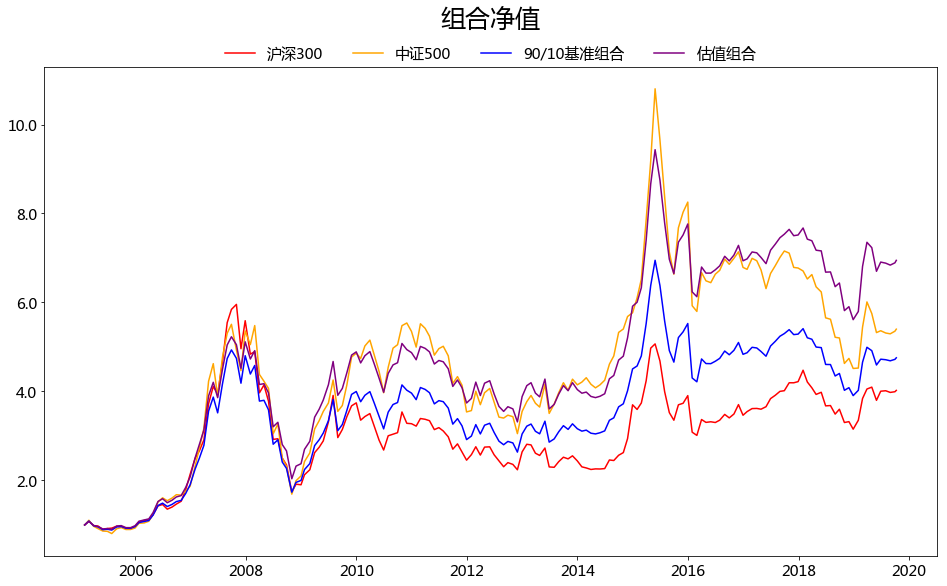

In [93]:
fig, ax = plt.subplots(figsize=(16, 9))

lns1 = ax.plot((1 + ret_df['300']).cumprod(), label=u'沪深300', color='red')
lns2 = ax.plot((1 + ret_df['500']).cumprod(), label=u'中证500', color='orange')
lns3 = ax.plot((1 + base_portfolio_ret).cumprod(), label=u'90/10基准组合', color='blue')
lns4 = ax.plot((1 + portfolio_ret).cumprod(), label=u'估值组合', color='purple')

lns = lns1 + lns2 + lns3 + lns4
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, frameon=False, fontsize=15, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.07))

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
vals = ax.get_yticks()
ax.set_yticklabels(['{:2.1f}'.format(x) for x in vals])

_ = ax.set_title(u'组合净值', fontsize=25, y=1.07)

In [94]:
metric(ret_df['300'])

Annual return: 9.84%
Sharpe ratio: 0.46
Annual volatility: 30.11%
Max drawdown: -70.75%


In [95]:
metric(ret_df['500'])

Annual return: 12.04%
Sharpe ratio: 0.51
Annual volatility: 33.82%
Max drawdown: -69.27%


In [96]:
metric(base_portfolio_ret)

Annual return: 11.09%
Sharpe ratio: 0.52
Annual volatility: 27.70%
Max drawdown: -64.79%


In [97]:
metric(portfolio_ret)

Annual return: 13.96%
Sharpe ratio: 0.62
Annual volatility: 27.15%
Max drawdown: -61.02%


In [114]:
year_ret_df = pd.DataFrame(columns=['300', '500', 'base', 'portfolio'])

In [115]:
year_ret_df['300'] = ret_df['300'].resample('Y').apply(lambda x: empyrical.cum_returns_final(x))
year_ret_df['500'] = ret_df['500'].resample('Y').apply(lambda x: empyrical.cum_returns_final(x))
year_ret_df['base'] = base_portfolio_ret.resample('Y').apply(lambda x: empyrical.cum_returns_final(x))
year_ret_df['portfolio'] = portfolio_ret.resample('Y').apply(lambda x: empyrical.cum_returns_final(x))

In [116]:
year_ret_df

,300,500,base,portfolio
2005-12-31,-0.032913,-0.067763,-0.035551,-0.016275
2006-12-31,1.210239,1.006841,0.974846,1.115332
2007-12-31,1.615459,1.866271,1.522229,1.458523
2008-12-31,-0.659493,-0.608006,-0.583373,-0.535357
2009-12-31,0.967124,1.312663,0.998481,1.057241
2010-12-31,-0.125129,0.100654,-0.008950,-0.003330
2011-12-31,-0.250145,-0.338270,-0.263634,-0.232298
2012-12-31,0.075545,0.002781,0.042964,0.038107
2013-12-31,-0.076468,0.168883,0.038944,0.040719
2014-12-31,0.516595,0.390071,0.424976,0.463490


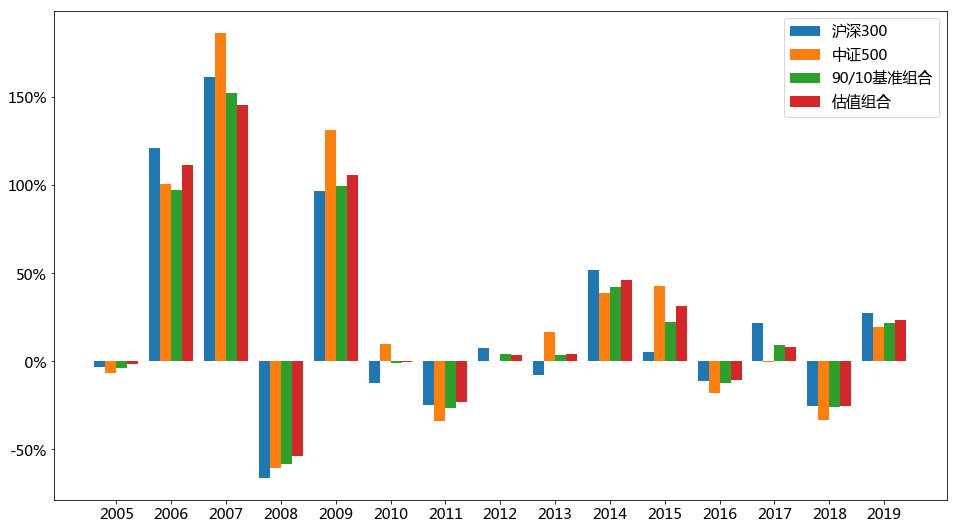

In [144]:
fig, ax = plt.subplots(figsize=(16, 9))

x = np.arange(year_ret_df.shape[0])

ax.bar(x - 0.3, year_ret_df['300'], width=0.2, align='center', label=u'沪深300')
ax.bar(x - 0.1, year_ret_df['500'], width=0.2, align='center', label=u'中证500')
ax.bar(x + 0.1, year_ret_df['base'], width=0.2, align='center', label=u'90/10基准组合')
ax.bar(x + 0.3, year_ret_df['portfolio'], width=0.2, align='center', label=u'估值组合')

ax.set_xticks(x)
ax.set_xticklabels(year_ret_df.index.year)

ax.legend(fontsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
vals = ax.get_yticks()
ax.set_yticklabels(['{:2.0f}%'.format(x*100) for x in vals])

_ = ax.set_title(u'', fontsize=25)